# Online Phase: PBDW

This notebook implements the online phase of the following algorithm:

- Parameterised-Background Data-Weak (PBDW) formulation

In [1]:
import numpy as np
import os
from IPython.display import clear_output
import pickle

import gmsh
from mpi4py import MPI
from dolfinx.io.gmshio import model_to_mesh
from dolfinx.fem import FunctionSpace

from pyforce.tools.write_read import ImportH5
from pyforce.tools.functions_list import FunctionsList
from pyforce.online.pbdw_synthetic import PBDW

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm

path_off ='./Offline_results/'

The geometry is imported from "ANL11A2_octave.geo", generated with GMSH. Then, the mesh is created with the gmsh module.

In [2]:
gdim = 2

model_rank = 0
mesh_comm = MPI.COMM_WORLD

# Initialize the gmsh module
gmsh.initialize()

# Load the .geo file
gmsh.merge('ANL11A2_octave.geo')
gmsh.model.geo.synchronize()

# Set algorithm (adaptive = 1, Frontal-Delaunay = 6)
gmsh.option.setNumber("Mesh.Algorithm", 6)

gmsh.model.mesh.generate(gdim)
gmsh.model.mesh.optimize("Netgen")

# Domain
domain, ct, ft = model_to_mesh(gmsh.model, comm = mesh_comm, rank = model_rank, gdim = gdim )
gmsh.finalize()

fuel1_marker    = 1
fuel2_marker    = 2
fuel_rod_marker = 3
refl_marker     = 4

void_marker     = 10
sym_marker      = 20

tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)

clear_output()

## Importing Snapshots

The snapshots are loaded and stored into suitable data structures.

In [3]:
# Defining the functional space
V = FunctionSpace(domain, ("Lagrange", 1))

# Define the variables to load
var_names = [
             'phi_1',
             'phi_2'
             ]

tex_var_names = [
                 r'\phi_1',
                 r'\phi_2'
                 ]

# Snapshot path
path_FOM = './Snapshots/'

################ Importing Snapshots ########################
test_snaps = list()

for field_i in range(len(var_names)):
    test_snaps.append(FunctionsList(V))

    tmp_FOM_list, _ = ImportH5(V, path_FOM+'test_snap_'+var_names[field_i], var_names[field_i])
    
    for mu in range(len(tmp_FOM_list)):
        test_snaps[field_i].append(tmp_FOM_list(mu))
    
    del tmp_FOM_list      
            
test_params = list()
for field_i in range(len(var_names)):
    with open(path_FOM+'./test.param', 'rb') as f:
        test_params.append(pickle.load(f))

Let us import the magic functions and sensors

In [4]:
bf = dict()

for field_i in range(len(var_names)):
    
    bf[var_names[field_i]] = ImportH5(V, path_off+'/BasisFunctions/basisPOD_'+var_names[field_i], 'POD_'+var_names[field_i])[0]
    
s = [0.1, 1., 2.5]

is_H1 = [False, True]
fun_space_label = ['L2', 'H1']

bs = dict()

for field in var_names:
    bs[field] = dict()
    for s_jj in s:
        bs[field]['s = {:.2f}'.format(s_jj)] = dict()
        for space in fun_space_label:
             bs[field]['s = {:.2f}'.format(s_jj)][space] = ImportH5(V, 
                                                                    path_off+'/BasisSensors/sensorsSGREEDYPOD_' + field+'_s_{:.2e}_'.format(s_jj)+space,
                                                                    'SGREEDYPOD_' +field+'_s_{:.2e}'.format(s_jj))[0]

## Online Reconstruction

In this section, the potentialities of PBDW are analysed: focusing on the effect of the Riesz representation.

The measures are polluted by synthetic random noise (modelled as uncorrelated Gaussian noise)
\begin{equation*}
\{y_m = v_m(u)+\epsilon_m\}_{m=1}^M \qquad \text{ with }\epsilon_m \sim \mathcal{N}(0,\sigma^2)
\end{equation*}
In this section, the test errors will be computed as
\begin{equation*}
\begin{split}
E_M[u] &= \left\langle \left\| u(\cdot;\,\boldsymbol{\mu}) - \mathcal{P}_M[u](\cdot;\,\boldsymbol{\mu})\right\|_{L^2(\Omega)}\right\rangle_{\boldsymbol{\mu}\in\Xi^{test}}\\
\varepsilon_M[u] &= \left\langle \frac{\left\| u(\cdot;\,\boldsymbol{\mu}) - \mathcal{P}_M[u](\cdot;\,\boldsymbol{\mu})\right\|_{L^2(\Omega)}}{\left\| u(\cdot;\,\boldsymbol{\mu}) \right\|_{L^2(\Omega)}}\right\rangle_{\boldsymbol{\mu}\in\Xi^{test}}
\end{split}
\end{equation*}
given $\mathcal{P}_M[u]$ the reconstruction operator with $M$ magic functions.

In [5]:
pbdw_online = dict()

for field in var_names:
    pbdw_online[field] = dict()
    for s_jj in s:
        pbdw_online[field]['s = {:.2f}'.format(s_jj)] = dict()
        for kk, space in enumerate(fun_space_label):
            pbdw_online[field]['s = {:.2f}'.format(s_jj)][space] = PBDW(bf[field],
                                                                        bs[field]['s = {:.2f}'.format(s_jj)][space],
                                                                        field, is_H1=is_H1[kk])

Let us compute the test errors for a single value of random noise $\sigma$, if the noise value increases too much the hyperparameter $\xi$ must be tuned properly as in [Maday and Taddei (2019)](https://epubs.siam.org/doi/10.1137/18M116544X).

In [6]:
noise_value = 1e-6

Nmax = 10
Mmax = 30

test_errors = dict()
comput_time = dict()

print('----------------------------')
for field_i, field in enumerate(var_names):
    print('Reconstructing '+field)
    test_errors[field] = dict()
    comput_time[field] = dict()
    for jj, s_jj in enumerate(s):
        print('     s = {:.2f}'.format(s[jj]))
        
        test_errors[field]['s = {:.2f}'.format(s_jj)] = dict()
        comput_time[field]['s = {:.2f}'.format(s_jj)] = dict()
        
        for kk, space in enumerate(fun_space_label):
            print('          - '+space)
            
            out = pbdw_online[field]['s = {:.2f}'.format(s_jj)][space].synt_test_error(test_snaps[field_i], 
                                                                                       N=Nmax, M = Mmax,
                                                                                       noise_value = noise_value)
            
            test_errors[field]['s = {:.2f}'.format(s_jj)][space] = [out[0], out[1]]
            comput_time[field]['s = {:.2f}'.format(s_jj)][space] = out[2]
            del out
                
    print('----------------------------')

----------------------------
Reconstructing phi_1
     s = 0.10
          - L2
          - H1
     s = 1.00
          - L2
          - H1
     s = 2.50
          - L2
          - H1
----------------------------
Reconstructing phi_2
     s = 0.10
          - L2
          - H1
     s = 1.00
          - L2
          - H1
     s = 2.50
          - L2
          - H1
----------------------------


Let us plot the test error.

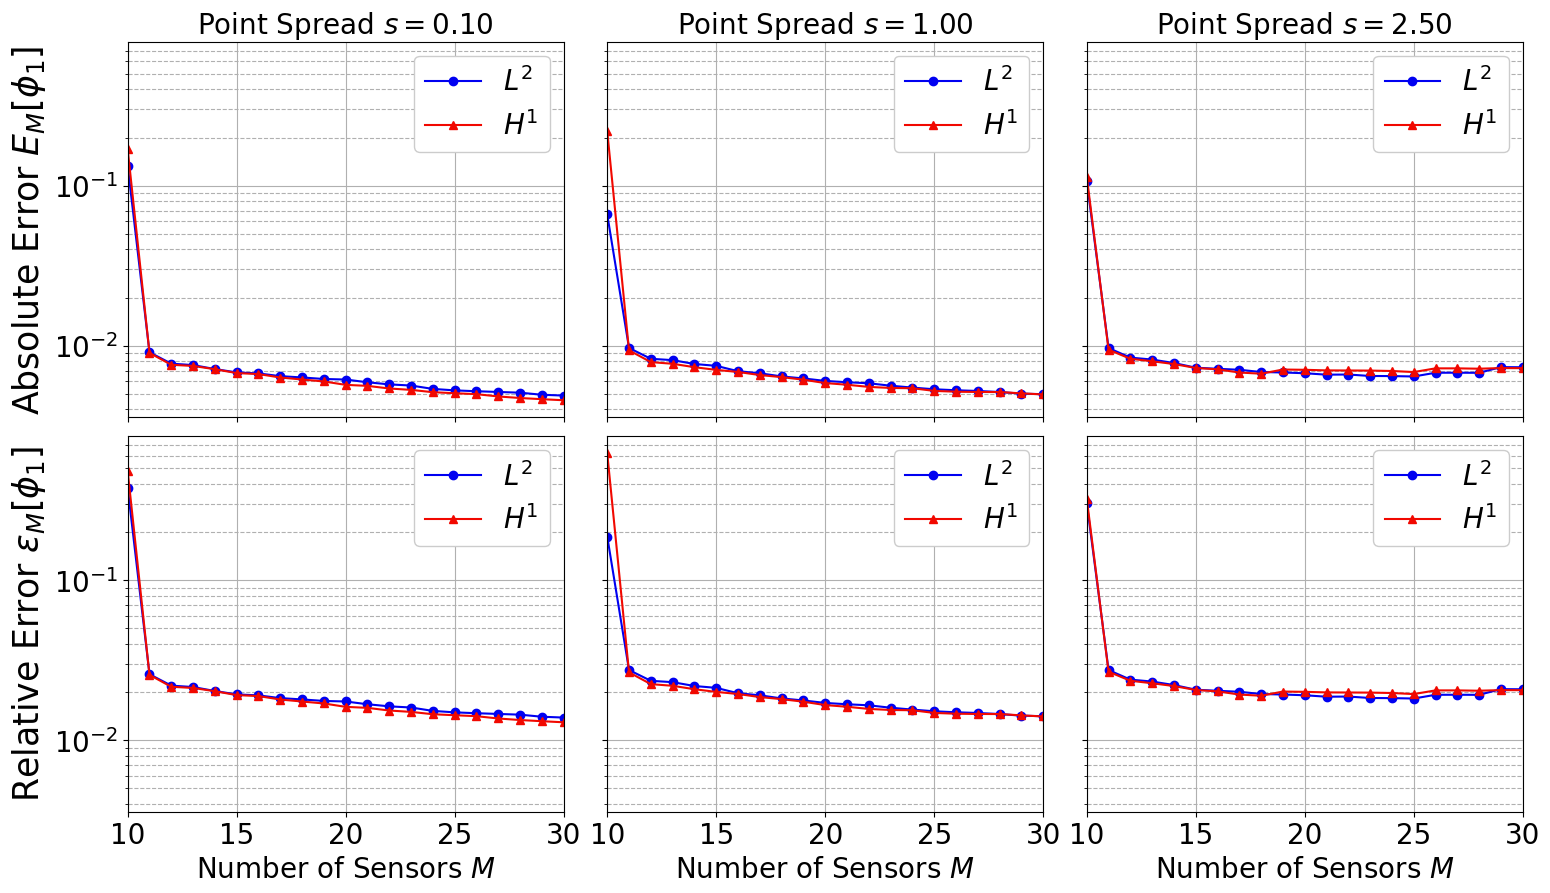

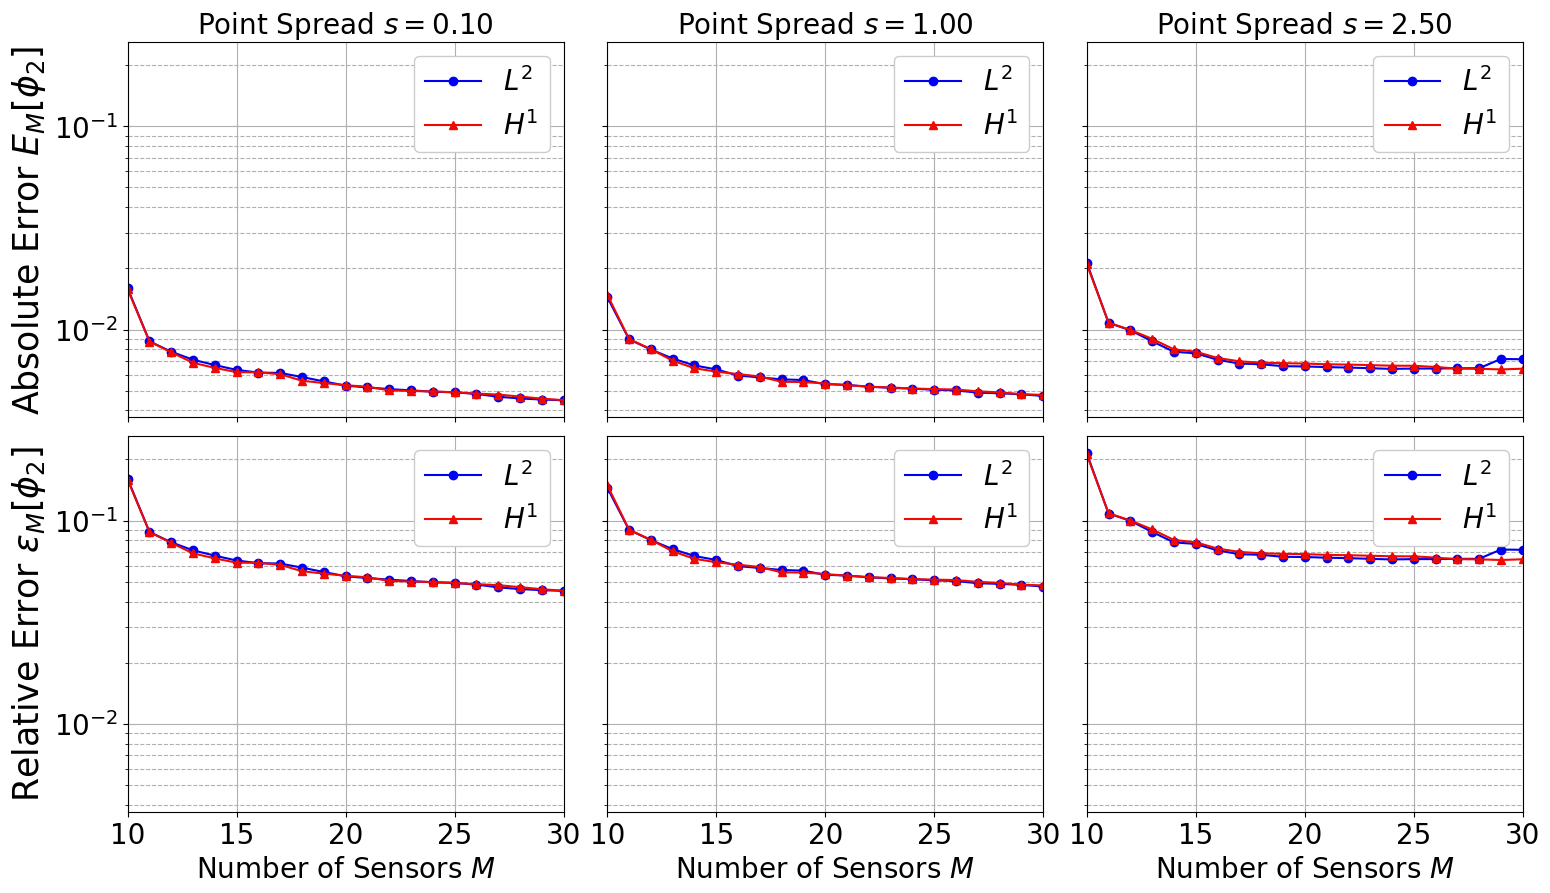

In [26]:
ls = 2
Mplot = np.arange(Nmax, Mmax+1,1)

tex_fun_space_label = [r'$L^2$', r'$H^1$']

for field_i, field in enumerate(var_names):
    fig, axs = plt.subplots(nrows = len(is_H1), ncols = len(s), sharey = True, sharex = True, figsize = (6 * len(s), 5 * len(is_H1)))

    for jj, s_jj in enumerate(s):
        
        linestyles = ['-o', '-^']
        colors = cm.jet(np.linspace(0.1, 0.9, len(fun_space_label)))
        for kk, space in enumerate(fun_space_label):
            
            for err_i in range(2):
                axs[err_i, jj].semilogy(Mplot, test_errors[field]['s = {:.2f}'.format(s_jj)][space][err_i], linestyles[kk],
                                    c=colors[kk], label=tex_fun_space_label[kk])
            
                axs[err_i, jj].grid(which = 'major', linestyle = '-')
                axs[err_i, jj].grid(which = 'minor', linestyle = '--')
                axs[err_i, jj].set_xlim(Nmax, Mmax)
                axs[err_i, jj].legend(framealpha=1, fontsize=20)
                axs[err_i, jj].tick_params(axis='both', labelsize=20)

                axs[0, jj].set_title(r'Point Spread $s={:.2f}$'.format(s[jj]), fontsize=20)
                axs[-1, jj].set_xlabel(r'Number of Sensors $M$', fontsize=20)

    axs[0,0].set_ylabel(r'Absolute Error $E_M['+tex_var_names[field_i]+']$', fontsize=25)
    axs[1,0].set_ylabel(r'Relative Error $\epsilon_M['+tex_var_names[field_i]+']$', fontsize=25)
            
    fig.subplots_adjust(hspace = 0.05, wspace = 0.1)

In the end, let us plot the computational time required by the Online Phase.

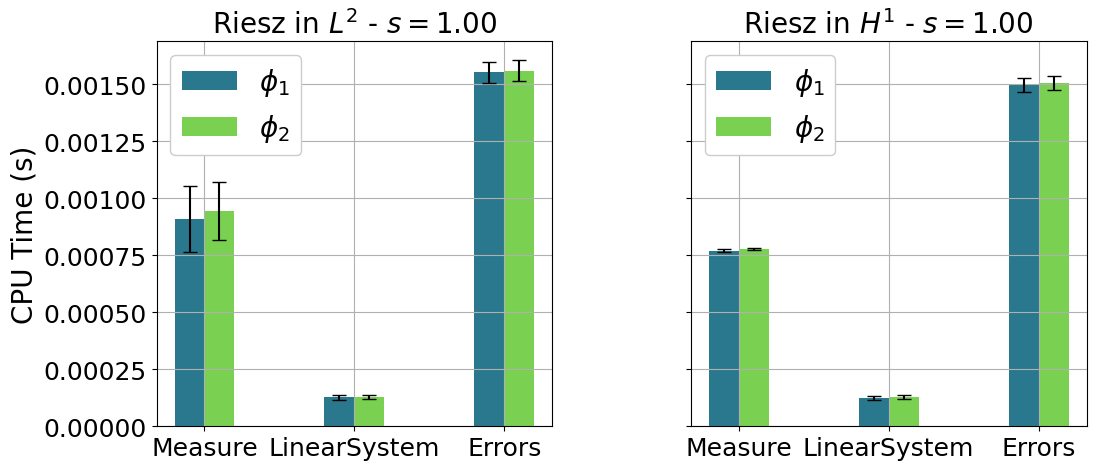

In [40]:
jj = 1


# Initialize subplots
fig, axs = plt.subplots(nrows = 1, ncols = len(fun_space_label), sharey = True, figsize=(12, 5))


for idx_ax, algo in enumerate(fun_space_label):
    
    # Iterate over field_i values
    colors = plt.cm.viridis(np.linspace(0.4, 0.8, len(var_names)))  # Choose a colormap
    for field_i, color in zip(range(len(var_names)), colors):
        means = []
        stds = []
        field = var_names[field_i]

        # Calculate mean and std for each key
        for key in list(comput_time[field]['s = {:.2f}'.format(s_jj)][algo].keys()):
            mean = np.mean(np.mean(comput_time[field]['s = {:.2f}'.format(s_jj)][algo][key], axis=0))
            std = np.std(np.mean(comput_time[field]['s = {:.2f}'.format(s_jj)][algo][key], axis=0))
            means.append(mean)
            stds.append(std)

        # Plot the bar chart with error bars for standard deviation
        bar_width = 0.2  # Adjust as needed
        ind = np.arange(len(list(comput_time[field]['s = {:.2f}'.format(s_jj)][algo].keys())))
        bars = axs[idx_ax].bar(ind + (field_i - len(var_names) / 4) * bar_width, means, bar_width, label=r'$'+tex_var_names[field_i]+'$', color=color, yerr=stds, capsize=5)
    
    if idx_ax == 0:
        axs[idx_ax].set_ylabel(r'CPU Time (s)', fontsize=20)
        axs[idx_ax].set_title(r'Riesz in '+tex_fun_space_label[idx_ax]+ ' - $s={:.2f}$'.format(s[jj]), fontsize=20)
    else:
        axs[idx_ax].set_title(r'Riesz in '+tex_fun_space_label[idx_ax]+ ' - $s={:.2f}$'.format(s[jj]), fontsize=20)
        
    axs[idx_ax].set_xticks(ind)
    axs[idx_ax].set_xticklabels(list(comput_time[field]['s = {:.2f}'.format(s_jj)][algo].keys()))
    axs[idx_ax].legend(framealpha=1, fontsize=20)
    axs[idx_ax].tick_params(axis='both', labelsize=18)
    axs[idx_ax].grid()
    
fig.subplots_adjust(wspace=0.35)

### Plotting the interpolant and the residual fields
Using *pyvista* and some additional functions the interpolant and its residual field $r[u] = | u - \mathcal{P}[u]|$ is plotted.

In [41]:
import pandas as pd

import vtk
import pyvista as pv
import dolfinx

pv.start_xvfb()

In [42]:
def grids(fun: dolfinx.fem.Function):
    topology, cell_types, geometry = dolfinx.plot.create_vtk_mesh(fun.function_space)
    u_grid = pv.UnstructuredGrid(topology, cell_types, geometry)
    u_grid.point_data['fun'] = fun.x.array[:].real
    u_grid.set_active_scalars('fun')
    return u_grid

def PlotFOM_vs_ROM( fom: FunctionsList, rom: dict, mu: int, title: str, varname: str,
                    clim = None, colormap = cm.jet, 
                    colormap_res = cm.plasma_r, clim_res = None):  
    
    keys = list(rom.keys())
    
    resolution = [1200, 600 * ( len(keys) + 1)]
    plotter = pv.Plotter(shape=(len(keys)+1, 2), off_screen=False, border=False, window_size=resolution)
    
    lab_fontsize = 32
    title_fontsize = 40
    zoom = 1.05
    
    dict_cb = dict(title = varname, width = 0.75, height = 0.1,
                    title_font_size=title_fontsize,
                    label_font_size=lab_fontsize,
                    n_labels=3,
                    color = 'k',
                    position_x=0.125, position_y=0.8,
                    shadow=False) 
    
    ############################ FOMs ###################################

    plotter.subplot(0,0)
    
    warped_fom = grids(fom.map(mu))
    if clim is None:
        clim = [min(fom(mu)), max(fom(mu))]
    
    dict_cb['title'] = 'FOM - $'+varname+'$'
    plotter.add_mesh(warped_fom, clim = clim, cmap = colormap, show_edges=False, scalar_bar_args=dict_cb)
    plotter.view_xy()
    plotter.camera.zoom(zoom)

    ############################ ROMs ###################################


    for key_i in range(len(keys)):
        plotter.subplot(1+key_i,0)
    
        warped_rom = grids(rom[keys[key_i]].map(mu))
        
        dict_cb['title'] = keys[key_i]+' - $'+varname+'$'
        plotter.add_mesh(warped_rom, clim = clim, cmap = colormap, show_edges=False, scalar_bar_args=dict_cb)
        plotter.view_xy()
        plotter.camera.zoom(zoom)

    ############################ Residuals ###################################

    max_res = 0.
    for key_i in range(len(keys)):
        plotter.subplot(1+key_i,1)
        
        residual = dolfinx.fem.Function(rom[keys[key_i]].fun_space)
        residual.x.array[:] = np.abs(rom[keys[key_i]](mu) - fom(mu))

        max_res = max([max_res, max(residual.x.array[:])])
        
        warped_rom = grids(residual)
        
        if clim_res is None:
            clim_res = [0, max_res]
        
        dict_cb['title'] = 'Residual '+keys[key_i]+' - $'+varname+'$'
        plotter.add_mesh(warped_rom, clim = clim_res, cmap = colormap_res, show_edges=False, scalar_bar_args=dict_cb)
        plotter.view_xy()
        plotter.camera.zoom(zoom)


    plotter.set_background('white', top='white')
    plotter.subplot(0,1)
    plotter.add_text(str(title), color= 'k', position=[50, 300], font_size=25)

    ## Save figure
    plotter.show()

Let us reconstruct one of the fields for the whole test set.

In [59]:
Mmax = 20
noise_value = 1e-6

jj = 1

rom_recs = list()

for field_i, field in enumerate(var_names):
    rom_recs.append({'L2': FunctionsList(V),
                     'H1': FunctionsList(V)})

    for mu in range(len(test_snaps[field_i])):
        for kk, space in enumerate(fun_space_label):
            
            out = pbdw_online[field]['s = {:.2f}'.format(s_jj)][space].reconstruct(test_snaps[field_i](mu), 
                                                                                   N = Nmax, M = Mmax, noise_value = noise_value,
                                                                                   )
            rom_recs[field_i][space].append(out[0])
            del out

Let us compare the fast and thermal flux with respect to some benchmark data.

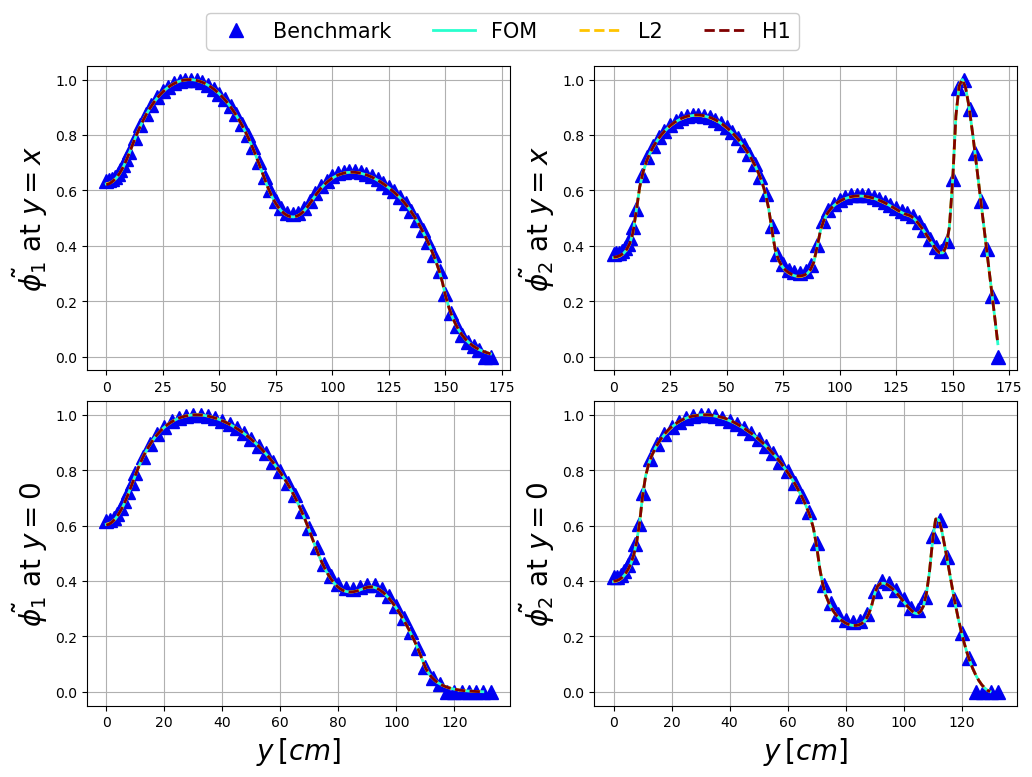

In [60]:
def extract_cells(domain, points):

    bb_tree = dolfinx.geometry.BoundingBoxTree(domain, domain.topology.dim)
    cells = []
    points_on_proc = []
    cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, points.T)
    colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, points.T)
    for i, point in enumerate(points.T):
        if len(colliding_cells.links(i))>0:
            points_on_proc.append(point)
            cells.append(colliding_cells.links(i)[0])
    xPlot = np.array(points_on_proc, dtype=np.float64)

    return xPlot, cells

Nhplot = 1000
xMax = 170
x_line = np.linspace(0, xMax + 1e-20, Nhplot)
points = [np.zeros((3, Nhplot)), 
          np.zeros((3, Nhplot))]
points[0][0] = x_line
points[1][0] = x_line
points[1][1] = x_line

extracted = [extract_cells(domain, point) for point in points]

## Uploading data from benchmark
bench_data = [pd.read_excel('../BenchmarkData/MGDiffusion_ANL11A2/anl11a2_data.xlsx', sheet_name='x-axis').to_numpy()/1000, 
              pd.read_excel('../BenchmarkData/MGDiffusion_ANL11A2/anl11a2_data.xlsx', sheet_name='Diagonal').to_numpy()/1000]

bench_labels = [r'$y=x$', r'$y=0$']

mark_size = 10
ls = 2
tickssize = 20

mu_bench = 220

fluxFigure, axs = plt.subplots(nrows = 2, ncols = len(var_names), figsize=(6 * len(var_names), 8))

for bench_i in range(2):
    xPlot = extracted[bench_i][0]
    cells = extracted[bench_i][1]
    for field_i in range(len(var_names)):
        colors = cm.jet(np.linspace(0.1,1, len(list(rom_recs[field_i].keys()))+2))
        axs[bench_i, field_i].plot(bench_data[bench_i][:, 0], bench_data[bench_i][:, field_i+bench_i+1] / max(bench_data[bench_i][:, field_i+bench_i+1]), '^', 
                                   c=colors[0], label = r'Benchmark', markersize=mark_size)
        axs[bench_i, field_i].plot(xPlot[:,0], test_snaps[field_i].map(mu_bench).eval(xPlot, cells) / max(test_snaps[field_i].map(mu_bench).eval(xPlot, cells)),
                                   c=colors[1], label = r'FOM', linewidth=ls)
        
        for algo_i, algo in enumerate(list(rom_recs[field_i].keys())):
            axs[bench_i, field_i].plot(xPlot[:,0], rom_recs[field_i][algo].map(mu_bench).eval(xPlot, cells) / max(rom_recs[field_i][algo].map(mu_bench).eval(xPlot, cells)),
                                       '--', c=colors[2+algo_i], label = algo, linewidth=ls)
            

        axs[bench_i, field_i].grid(which='major',linestyle='-')
        axs[bench_i, field_i].grid(which='minor',linestyle='--')
        axs[bench_i, field_i].set_ylabel(r"$\tilde{"+tex_var_names[field_i]+"}$ at "+bench_labels[bench_i], fontsize=20)
        
        if bench_i + 1 == 2:
            axs[bench_i, field_i].set_xlabel(r"$y\,[cm]$",fontsize=20)    
        
Lines, Labels = axs[0,0].get_legend_handles_labels()
fluxFigure.legend(Lines, Labels, framealpha=1, loc=(0.2, 0.935), ncols = 2+len(rom_recs[0]), fontsize=15)
fluxFigure.subplots_adjust(wspace=0.2, hspace=0.1, top = 0.91)

Let us make some contour plots

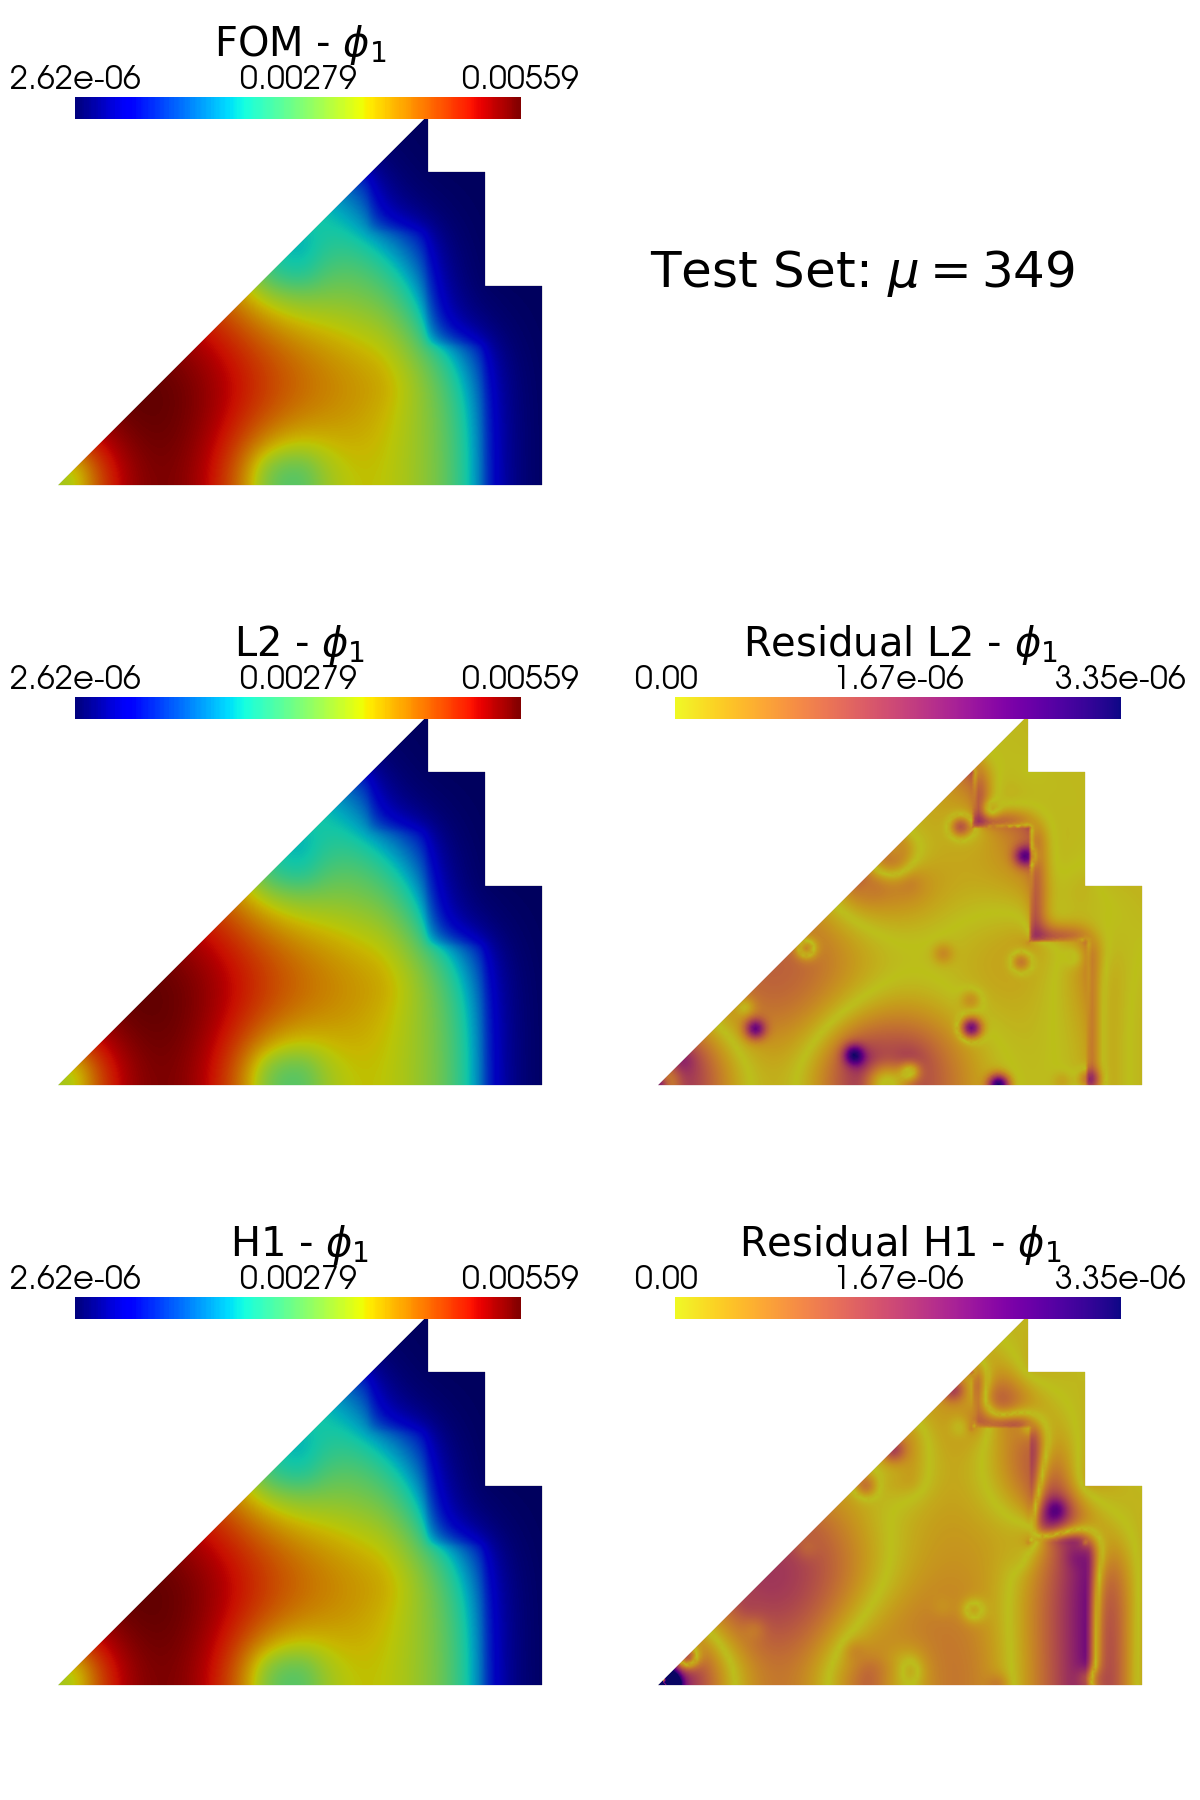

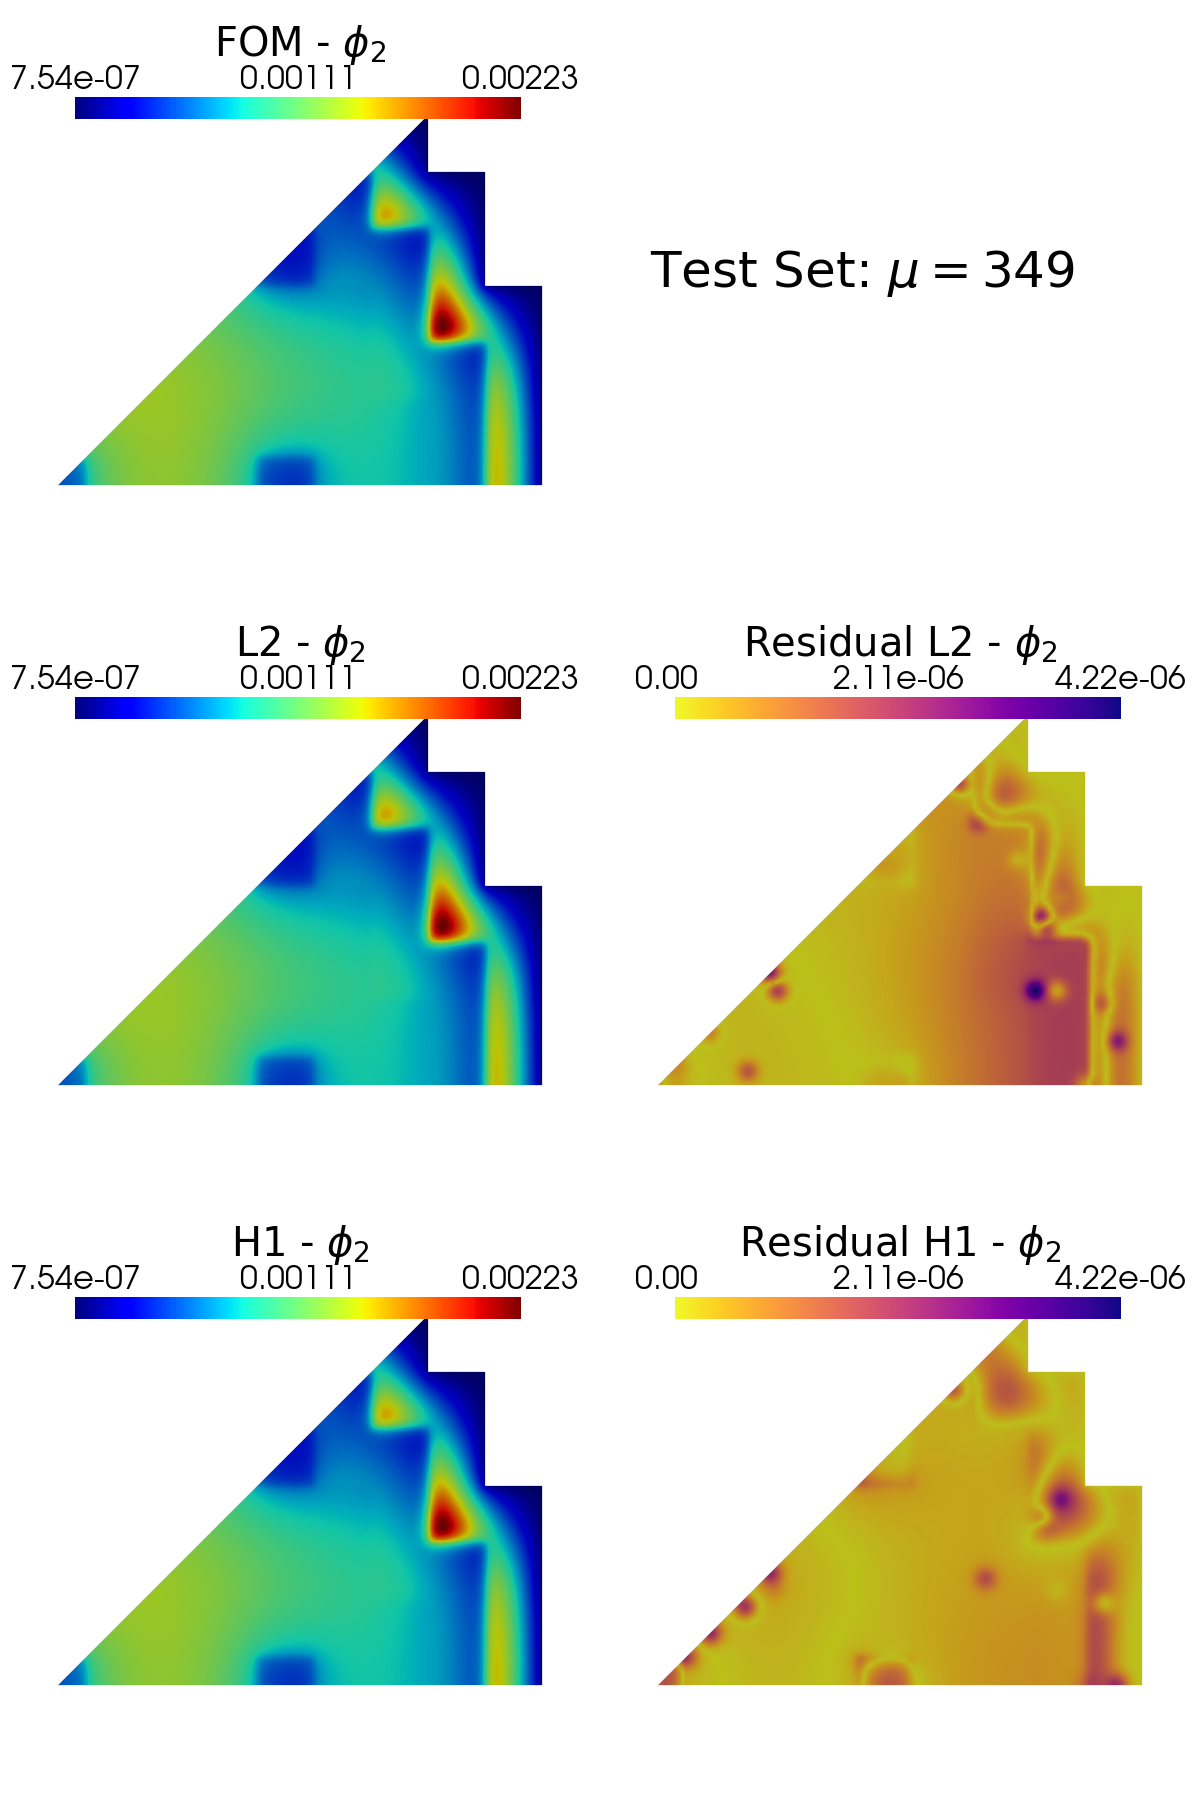

In [61]:
for field_i in range(len(var_names)):
    PlotFOM_vs_ROM(test_snaps[field_i], rom_recs[field_i], mu = mu_bench, title='Test Set: $\mu = '+str(mu)+'$',
                   varname=tex_var_names[field_i])